In [1]:
cd ..

c:\Users\jeong\Desktop\python-practices\contrastive-triplet-practice


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils
import torch.utils.data
import torchvision
import torchvision.transforms

import reid.datasets.paired
import reid.losses
import reid.models
import reid.utilities

In [3]:
# Get Device
device = reid.utilities.device()
reid.utilities.manual_seed(777)

In [4]:
# Prepare Datasets
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_inv = torchvision.transforms.Compose([
    # torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2)),
])

dataset = torchvision.datasets.MNIST('./data/mnist', transform=transform, download=True)
dataset_train = reid.datasets.paired.DoublePairedVisionDataset(
    dataset)
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=128*30,
                                               shuffle=True,
                                               num_workers=0)

In [5]:
# Create Model
model = reid.models.simple_cnn()
model.to(device)
criterion = reid.losses.ContrastiveLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [6]:
# Or Load
# model = reid.models.resnet18_custom(False)
# model.load_state_dict(torch.load('./model_epoch_49.pth'))
# model = model.to(device).eval()

In [12]:
# Train
loss_epoch = []
num_epochs = 30
for epoch in range(num_epochs):
    loss_batch = 0.0
    for i, batch in enumerate(dataloader_train, 0):
        inputs0, inputs1, labels = batch
        inputs0 = inputs0.to(device)
        inputs1 = inputs1.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = criterion(model(inputs0), model(inputs1), labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        loss_batch += loss
    lr_sche.step()
    loss_batch /= i+1
    print(f'epoch: {epoch}, loss: {loss_batch}')
    loss_epoch.append(loss_batch)

    if epoch % 10 == 9:
        reid.utilities.save_model(model, f'contra_simple_mnist_{epoch}')

epoch: 0, loss: 1.022857904434204
epoch: 1, loss: 1.0228495597839355
epoch: 2, loss: 1.0224558115005493
epoch: 3, loss: 1.0230603218078613
epoch: 4, loss: 1.0224801301956177
epoch: 5, loss: 1.022229552268982
epoch: 6, loss: 1.021920919418335
epoch: 7, loss: 1.0219974517822266
epoch: 8, loss: 1.0213631391525269
epoch: 9, loss: 1.0211453437805176
epoch: 10, loss: 1.0207419395446777
epoch: 11, loss: 1.0210168361663818
epoch: 12, loss: 1.0208150148391724
epoch: 13, loss: 1.020431399345398
epoch: 14, loss: 1.0205556154251099
epoch: 15, loss: 1.0201958417892456
epoch: 16, loss: 1.0203064680099487
epoch: 17, loss: 1.0201894044876099
epoch: 18, loss: 1.0198160409927368
epoch: 19, loss: 1.0198734998703003
epoch: 20, loss: 1.0193893909454346
epoch: 21, loss: 1.0201075077056885
epoch: 22, loss: 1.0202966928482056
epoch: 23, loss: 1.0193976163864136
epoch: 24, loss: 1.0194035768508911
epoch: 25, loss: 1.0196173191070557
epoch: 26, loss: 1.019391417503357
epoch: 27, loss: 1.0196646451950073
epoch: 

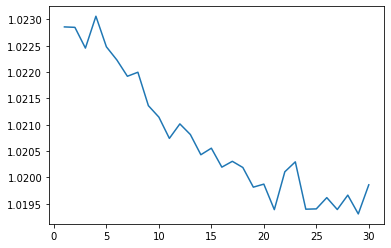

In [13]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_epoch)
plt.show()

In [14]:
# Test
def visualize_batch(model, batch, transform, device):
    anchors, others, labels = batch

    for i in range(len(anchors)):
        anchor = anchors[i].unsqueeze(dim=0).to(device)
        other = others[i].unsqueeze(dim=0).to(device)

        # calc distance between anchor and X
        output_anchor = model(anchor)
        output_other = model(other)
        distance = torch.nn.functional.pairwise_distance(
            output_anchor, output_other)

        # make grid
        imgs = torch.cat((transform(anchor), transform(other)), 0)
        plt.imshow(
            torchvision.utils.make_grid(imgs).cpu().permute(1, 2, 0))
        plt.text(75,
                 8,
                 'dist: {:.8f}'.format(distance.item()),
                 fontweight='bold',
                 bbox={
                     'facecolor': 'white',
                     'alpha': 0.8,
                     'pad': 10
                 })
        plt.show()

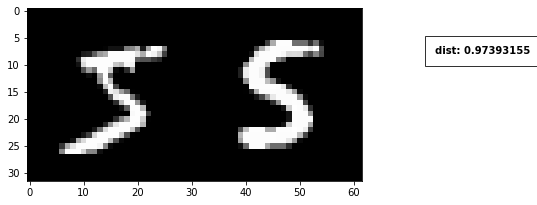

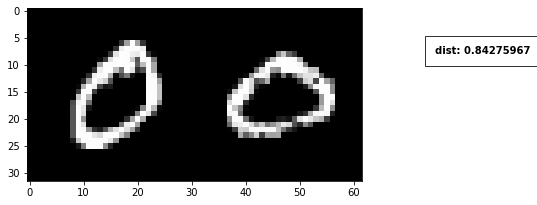

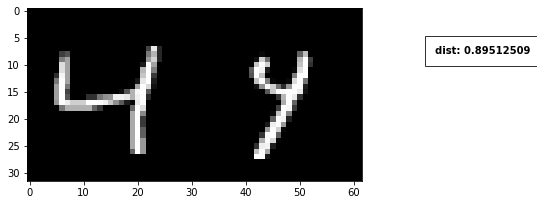

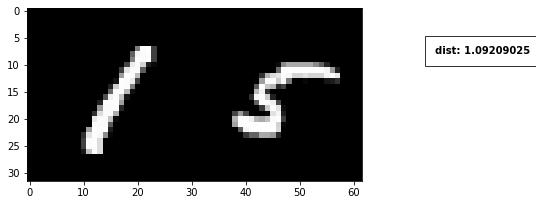

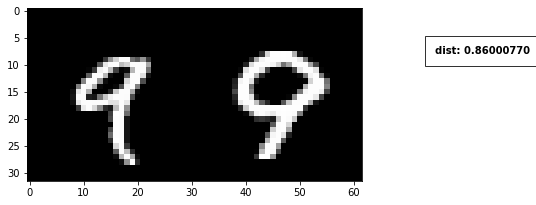

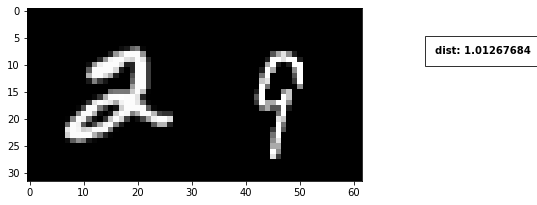

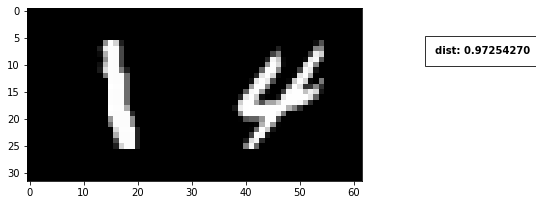

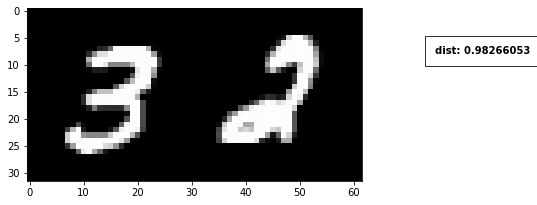

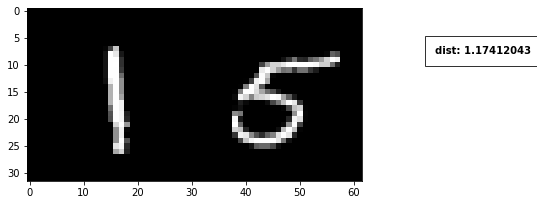

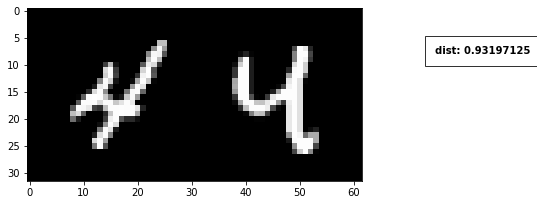

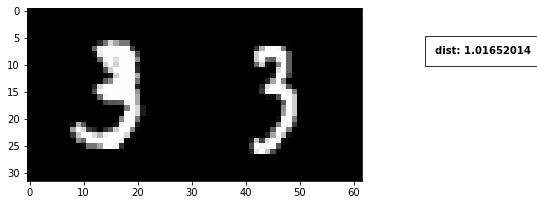

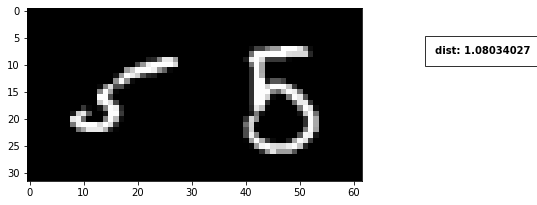

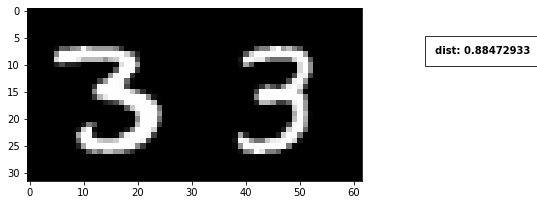

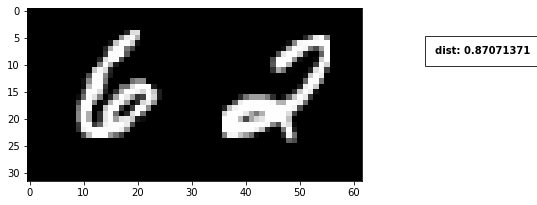

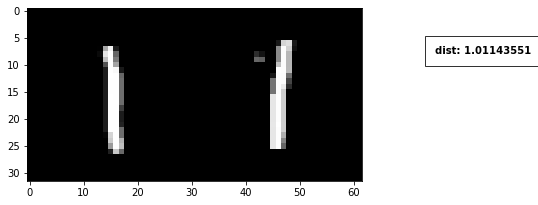

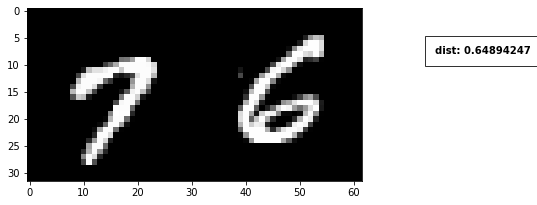

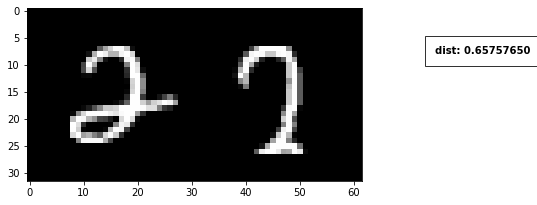

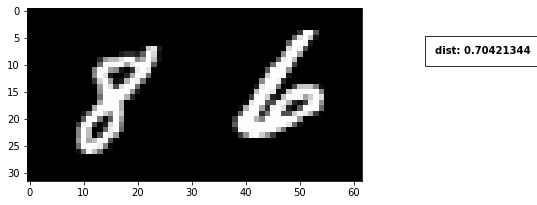

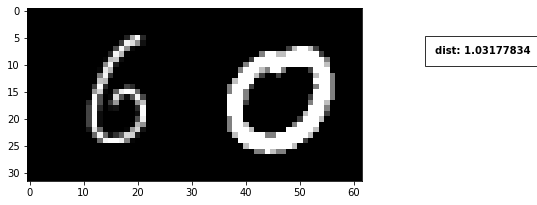

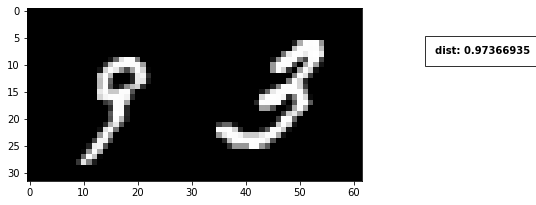

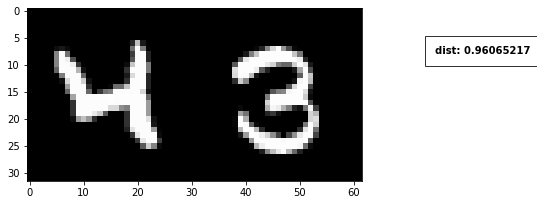

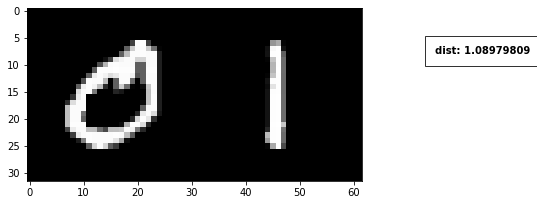

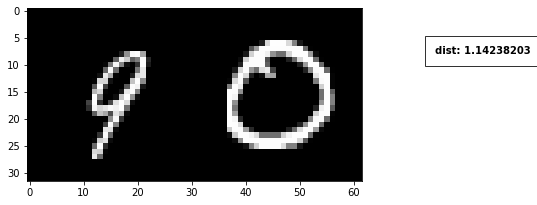

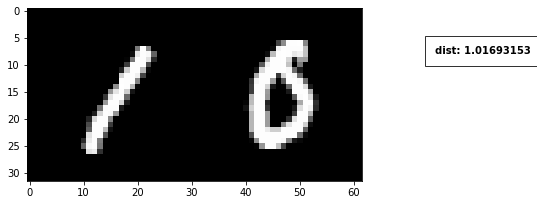

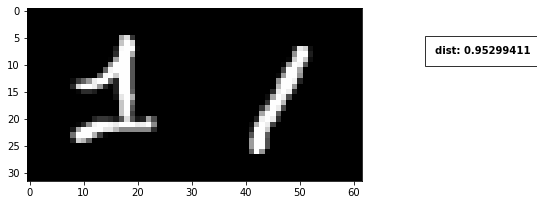

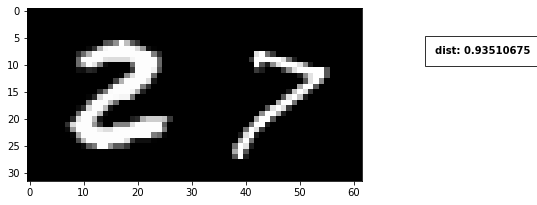

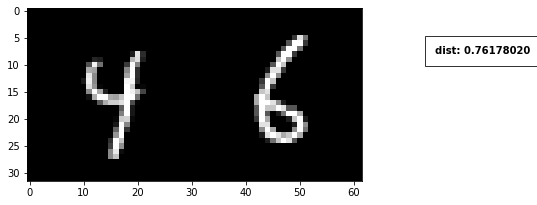

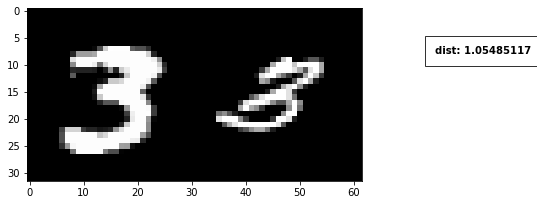

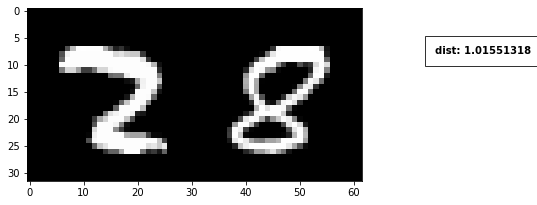

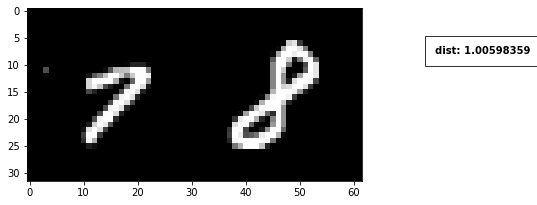

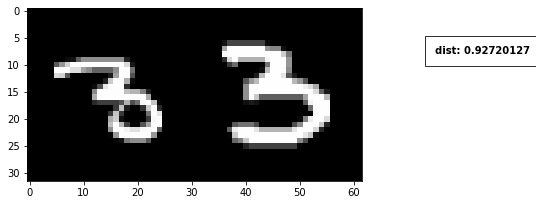

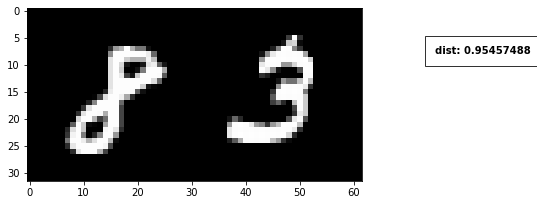

In [15]:
dataloader_test = torch.utils.data.DataLoader(dataset_train,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=0)
batch = next(iter(dataloader_test))
visualize_batch(model, batch, transform_inv, device)

In [16]:
f'classes: {len(dataset_train._classes)}, size: {len(dataset_train)}'

'classes: 10, size: 60000'